In [1]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import timedelta
from astropy import units
from numpy import random
plt.rcParams['font.family']=['gothambook','gotham','gotham-book','serif']

import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.utils import convert_units
from clmm.support.sampler import samplers
from scipy.stats import kstest
import scipy.integrate as integrate

In [3]:
np.random.seed(0)

# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
    
cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
shapenoise    = 1.e-3 # True ellipticity standard variation

# Create galaxy catalog and Cluster object
data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)

gc.compute_tangential_and_cross_components(geometry="flat")
radius = convert_units(gc.galcat['theta'], 'radians', 'Mpc', redshift=gc.z, cosmo=cosmo)

# Create binning profile por binned methods
bin_edges = da.make_bins(0.7, 4, 50, method="evenlog10width")
profile = gc.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)

In [4]:
z_dist_kde = Ncm.StatsDist1dEPDF.new_full(2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
r_dist_kde = Ncm.StatsDist1dEPDF.new_full(2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

for z in gc.galcat['z']:
    z_dist_kde.add_obs(z)
        
for r in radius:
    r_dist_kde.add_obs(r)

z_dist_kde.prepare()
r_dist_kde.prepare()

z_dist = [z_dist_kde.eval_p(z) for z in gc.galcat['z']]
z_max = max(z_dist)

In [16]:
rr = np.logspace(np.log10(0.5), np.log10(5), 100)

m_est_clmm = 8.534274335137409e+14
m_est_1_2  = 9.92086026e+14
m_est_2_1  = 1.002363874771482e+15

gt_model_clmm = clmm.compute_reduced_tangential_shear(rr, m_est_clmm, concentration, cluster_z, z_max, cosmo, delta_mdef=200, halo_profile_model='nfw')

gt_model_1_2  = clmm.compute_reduced_tangential_shear(rr, m_est_1_2, concentration, cluster_z, z_max, cosmo, delta_mdef=200, halo_profile_model='nfw')

gt_model_2_1  = clmm.compute_reduced_tangential_shear(rr, m_est_2_1, concentration, cluster_z, z_max, cosmo, delta_mdef=200, halo_profile_model='nfw')

In [ ]:
fig = plt.figure(figsize=(10, 6))

fig.gca().scatter(r1, gt_profile1, color='orange',
                  label='binned mock data 1, M_input = %.3e Msun/h' % cluster_m)
fig.gca().plot(rr, gt_model1, color='orange',
               label='best fit model 1, M_fit = %.3e' % m_est1)

fig.gca().scatter(r2, gt_profile2, color='blue', alpha=0.5,
                  label='binned mock data 2, M_input = %.3e Msun/h' % cluster_m)
fig.gca().plot(rr, gt_model2, color='blue', linestyle='--', alpha=0.5,
               label='best fit model 2, M_fit = %.3e' % m_est2)

plt.semilogx()
plt.semilogy()

plt.legend()
plt.xlabel('R [Mpc]', fontsize=fsize)
plt.ylabel('reduced tangential shear', fontsize=fsize)

Text(0, 0.5, 'reduced tangential shear')

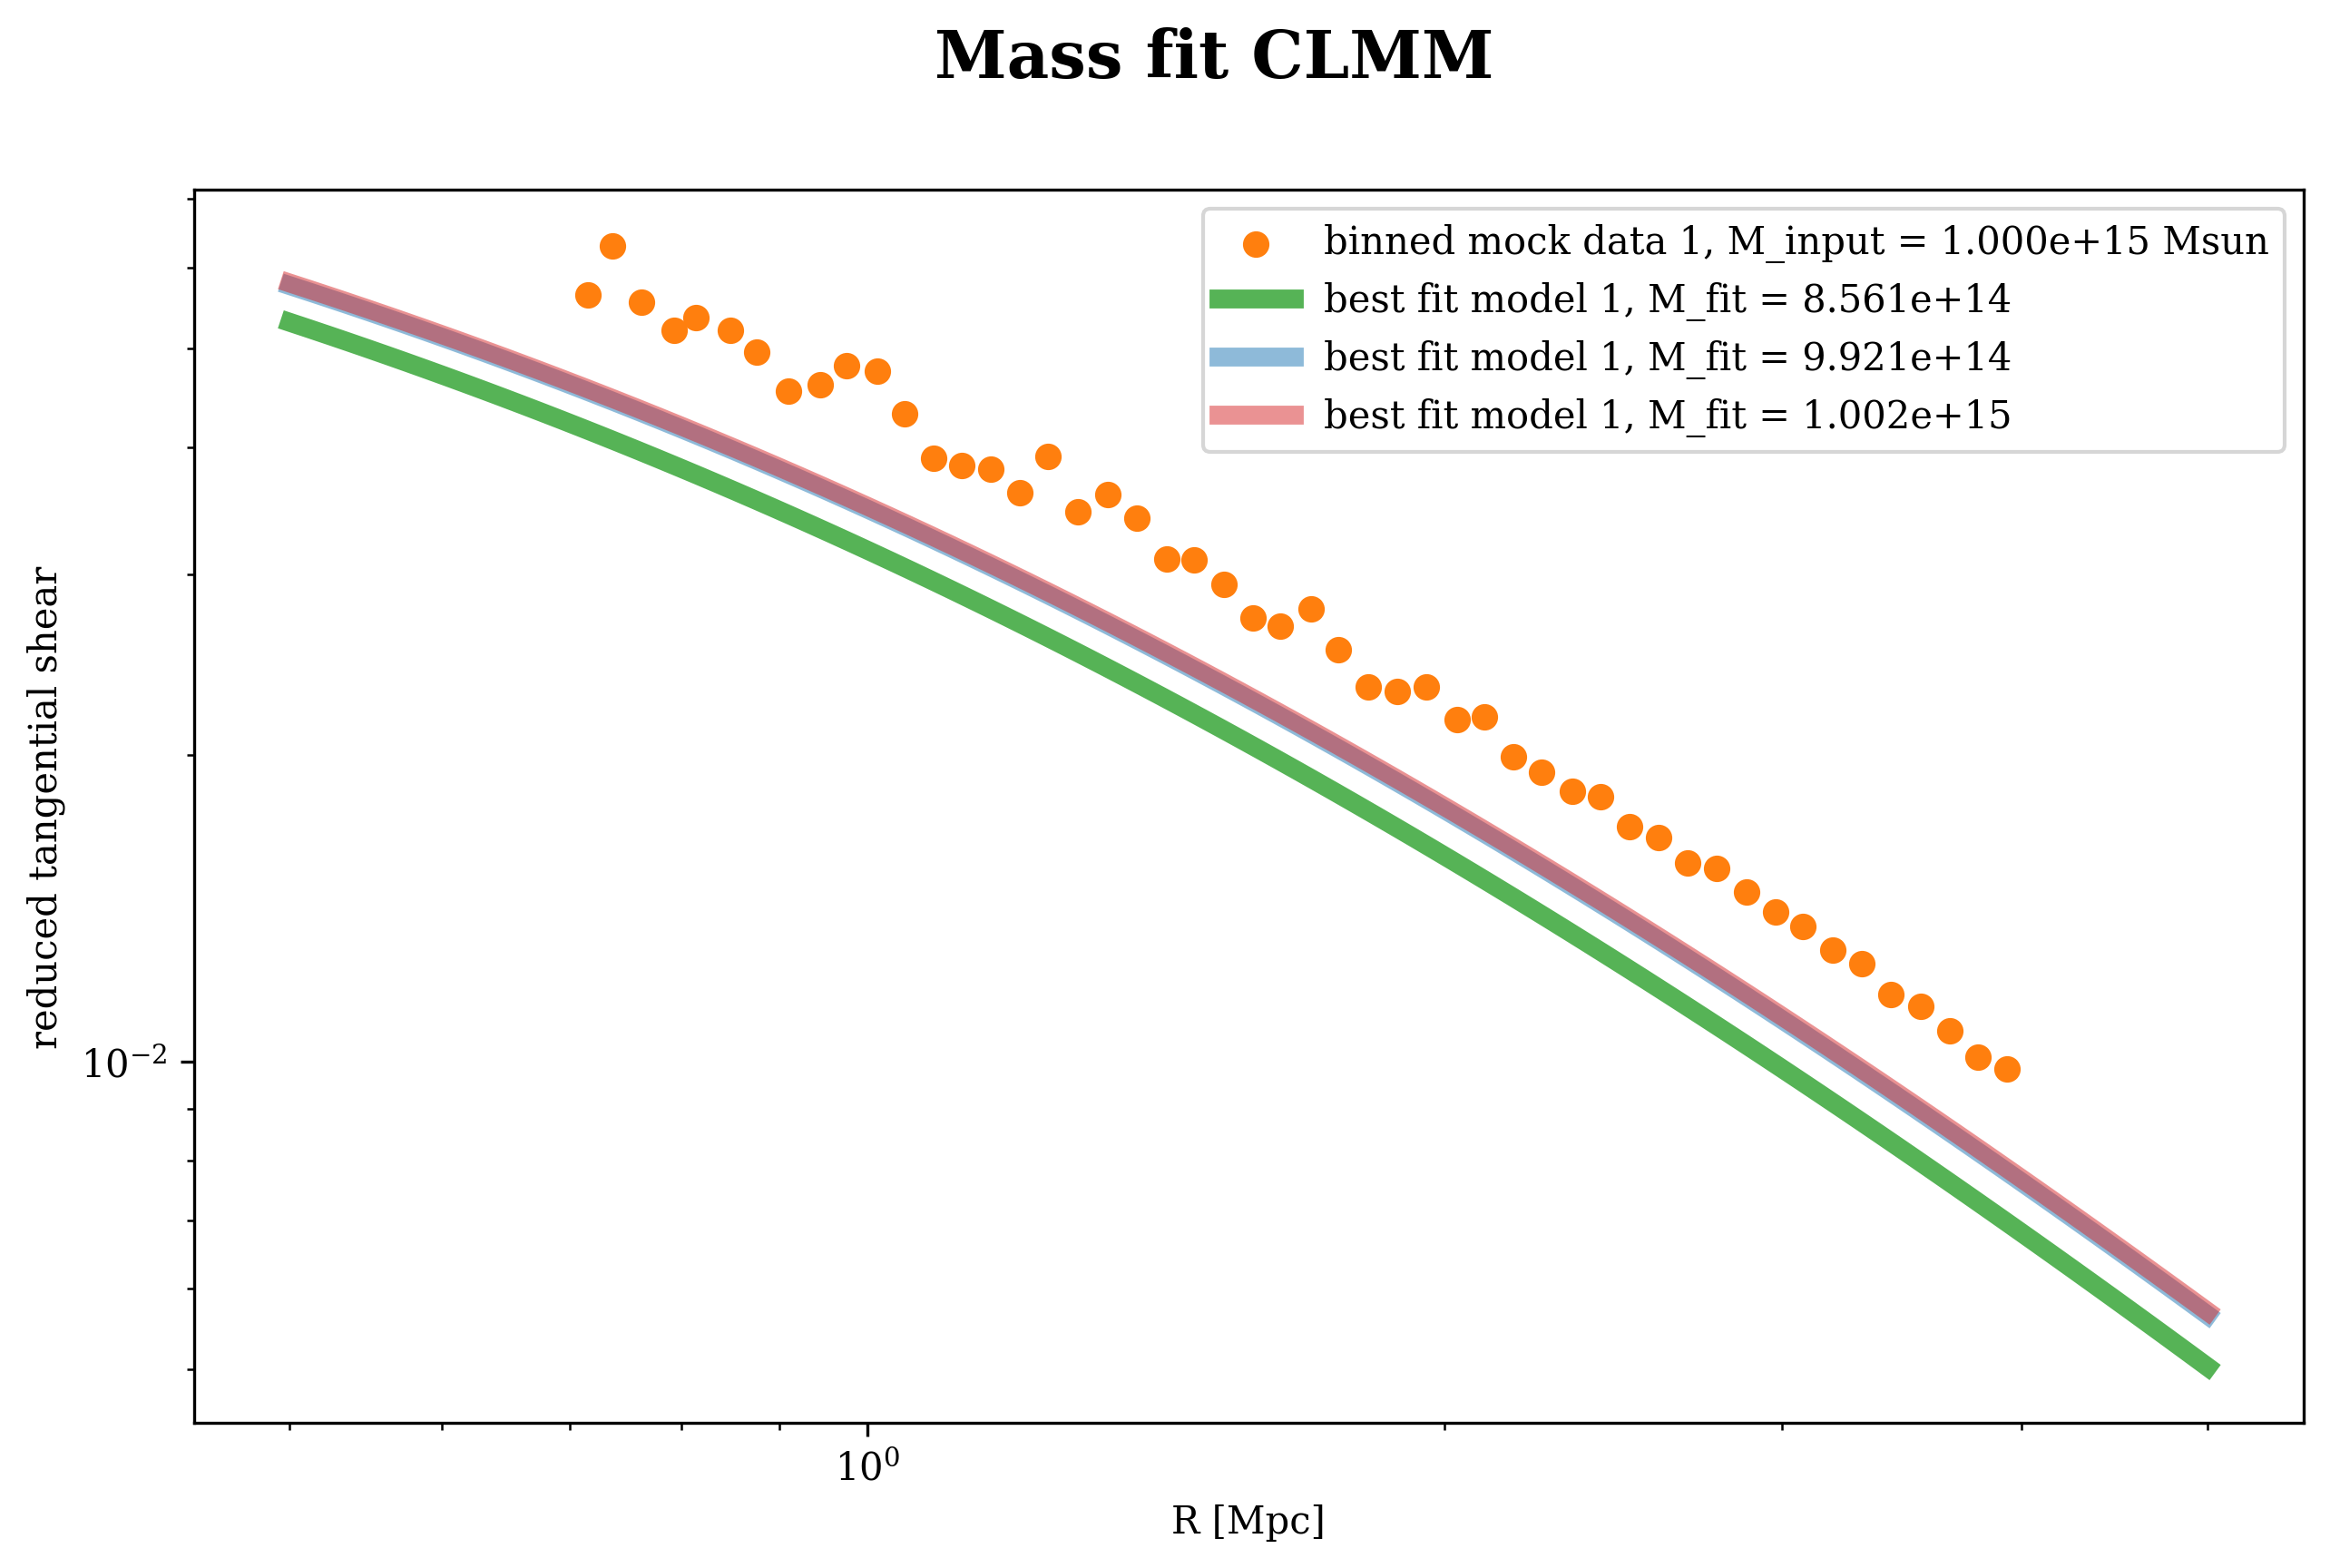

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
fig.suptitle(f'Mass fit CLMM', size='xx-large', weight='bold')

ax.scatter(profile['radius'], profile['gt'], color='tab:orange', label='binned mock data 1, M_input = %.3e Msun' % cluster_m)
ax.plot(rr, gt_model_clmm, color='tab:green', alpha=0.8, linewidth=5, label='best fit model 1, M_fit = %.3e' % m_est_clmm)
ax.plot(rr, gt_model_1_2, color='tab:blue', alpha=0.5, linewidth=5, label='best fit model 1, M_fit = %.3e' % m_est_1_2)
ax.plot(rr, gt_model_2_1, color='tab:red', alpha=0.5, linewidth=5, label='best fit model 1, M_fit = %.3e' % m_est_2_1)

plt.semilogx()
plt.semilogy()

plt.legend()
plt.xlabel('R [Mpc]')
plt.ylabel('reduced tangential shear')

In [17]:
real_mass = 1e15

error = []

for m in [m_est_clmm, m_est_1_2, m_est_2_1]:
    error.append(abs(real_mass-m)/real_mass)

for e in error:
    print(f'{e} percentual {e*100:.2g}')

0.14657256648625913 percentual 15
0.007913974 percentual 0.79
0.002363874771482 percentual 0.24
